# Setup

In [1]:
''' magic 4u'''
%load_ext autoreload
%autoreload 2

In [2]:
'''Get stuff you need'''
import numpy as np
from tqdm import tnrange
from tqdm.notebook import tqdm as tdqm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from matplotlib import gridspec
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import scipy.io
from IPython.core.debugger import set_trace
import scipy.ndimage.filters as filt
import pandas as pd
import seaborn as sns
import math

from pipeline import get_data as get
from pipeline import process_spikes as ps

from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from sklearn.metrics import silhouette_samples, silhouette_score

from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks
from itertools import combinations

In [3]:
''' Define formatting for figures '''

from matplotlib import rc 
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['svg.fonttype'] = 'none'

In [4]:
''' Load in Animal Metadata '''

animalmeta = pd.read_csv('C:/Users/Python/Desktop/Dryad/MouseMetadata.csv') # adjust path name

# define some useful lists of animals based on metadata
all_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3),'Animal_ID'])
all_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2),'Animal_ID'])
all_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1),'Animal_ID'])

cohorta_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'A'),'Animal_ID'])
cohortb_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'B'),'Animal_ID'])
cohortc_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'C'),'Animal_ID'])
cohortd_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'D'),'Animal_ID'])

RF_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'SM'),'Animal_ID'])

all_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F'),'Animal_ID'])
all_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M'), 'Animal_ID'])
RF_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'SM'),'Animal_ID'])

animalmeta.head()

,Animal_ID,Task,Cohort,Probe_Control,Sex,Sac_Date,Frozen_Hemisphere,DOB,Age_WholeMonth,Age_ExtraDays,Age_Month,Aged_Days,Age_Group,Behavior_Sessions,Neural_Sessions
0,A3,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
1,A4,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
2,A5,RF,A,0,F,4/6/2021,L,4/23/2019,23,14,23.487,714,3,6,6
3,A6,RF,A,0,F,4/6/2021,R,4/23/2019,23,14,23.487,714,3,6,6
4,A7,RF,A,0,F,4/19/2021,L,5/29/2019,22,21,22.730,691,3,6,6


In [5]:
''' Complete List of Mice & Neural Data Sessions '''
all_mice = np.array(animalmeta.Animal_ID)

#list of session IDs in order of mouse names
all_sessions = ([['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'], #A3
             ['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'], #A4
             ['0401_record1','0401_record2b','0403_record3','0404_record4','0405_record5','0406_record6'], #A5
             ['0401_record1','0402_record2','0403_record3','0404_record4','0405_record5','0406_record6'], #A6
             ['0414_record1','0415_record2','0416_record3','0417_record4','0418_record5','0419_record6'], #A7
             ['1024_record1','1025_record2','1026_record3','1027_record4','1028_record5_2'], #Y2; _6 excluded
             ['1016_record1','1019_record3','1020_record4','1021_record5','1022_record6'], #Y3; _2 not collected
             ['1114_record1','1115_record2','1116_record3','1117_record4','1118_record5','1119_record6'], # end cohort A
             ['051822_record1','051922_record2','052022_record3','052122_record4','052222_record5','052322_record6'],
             ['050522_record1','050622_record2','050722_record3','050822_record4','050922_record5','051022_record6'],
             ['050522_record1','050622_record2','050722_record3','050822_record4','051022_record6'], #Y11_5 not collected
             ['062222_record3','062322_record4','062522_record5'], #Y16_1 & 2 not collected, _6 neural excluded
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'],
             ['062022_record1','062122_record2','062222_record3','062322_record4','062522_record5','062622_record6'],
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'], 
             ['051922_record2','052022_record3'], # end cohort B; Y9 051822_1 excluded; _2 and &_3 excluded from behavior
             ['083022_record1','083122_record2','090122_record3'], 
             ['083022_record1','083122_record2','090122_record3','090222_record4','090322_record5','090422_record6'],
             ['083022_record1','083122_record2','090122_record3','090222_record4'], #A16_5 excluded, A16_6 not collected 
             ['082322_record1','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['082322_record1real','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['103122_record2','110122_record3','110222_record4','110322_record5rep','110422_record6','110522_record7'],
             ['110622_record1','110722_record2','110822_record3','110922_record4','111022_record5','111122_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4','110322_record5','110422_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4'], #MA7_5 excluded, 6 not collected
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'], 
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'], #end cohortc
             ['012723_record2','012823_record3','012923_record4','013023_record5','013123_record6','020123_record7'],
             ['012623_record1','012723_record2','012823_record3','012923_record4','013023_record5','013123_record6'],
             ['012923_record2','013023_record3','013123_record4','020123_record5','020223_record6','020323_record7'],
             ['020923_record1','021023_record2','021123_record3','021223_record4','021323_record5','021423_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5rep','022123_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'] #end cohort d 
            ]) #list of sessions

# Edit these paths

In [6]:
#Inputs
folder = 'C:/Users/Python/Desktop/Dryad/waveform_metrics/' # adjust to match location of this Dryad repo folder
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/' # adjust to match output of Import & Filter notebook

#Output (create folders to hold the output of this notebook; then match the name of this repository below)
save_folder = 'C:/Users/Python/Desktop/LocalData/shuffscores/'
plotsave_folder = 'C:/Users/Python/Desktop/LocalData/FigureS6/' 

# Classify putative inhibitory interneurons based on waveforms.

First, in all sessions, you will identify putative inhibitory interneurons based on dual thresholds on FR and waveform duration. This takes <5 minutes to run for all sessions.  

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

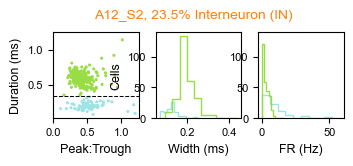

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Mean, SEM % interneurons / session:
24.549683794466404 0.5465142433290131


In [7]:
''' Classify putative inhibitory interneurons & plot Figure S6A'''

#load all neural data sessions
mice = all_mice
sessions = all_sessions

# Make a dict to hold data
data = {}

for session, m in zip(sessions, mice):
    data[m] = {}
    
    for s in session:
        data[m][s] = {}
    
intperc = [] 

colors = ['#9DE4E5','#97DD43']

for m, session in zip(mice,sessions):
    
    seshcount = 1 
    
    for s in tdqm(session):
        d = data[m][s]   
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        # load waveform parameters of interest for good cells only, drop rows w/ NaN, standardize for kmeans clustering
        file_name = m + '_' + str(seshcount) + '_metrics.csv'
        metrics = pd.read_csv(folder + file_name)
        fullgcmetrics = metrics[metrics['cluster_id'].isin(list(cell_IDs))]
        gcmetrics = fullgcmetrics.dropna(subset = ['duration','PT_ratio'])
        
        duration = np.asarray(gcmetrics['duration'])
        PTR = np.asarray(gcmetrics['PT_ratio'])
        halfwidth = np.asarray(gcmetrics['halfwidth'])
        recslope = np.asarray(gcmetrics['recovery_slope'])
        firingrate = np.asarray(gcmetrics['firing_rate'])
        
        #examine duration threshold and plot
        idx = np.where((duration < 0.35) | (firingrate > 40))[0]
        #print('Interneurons %: ' + str(len(idx)/len(cell_IDs)*100))
        oppidx = np.setdiff1d(np.arange(0,len(firingrate),1), idx)
        
        intperc = np.append(intperc, np.round(100*len(idx)/len(cell_IDs), 2))
        
        #Plot Figure S6A:
        if (m == 'A12') and (s == '051922_record2'):
            fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (3.75,1.25))
            ax1.scatter(PTR[idx], duration[idx], color = colors[0], alpha = 1, s = 5, edgecolor = 'None')
            ax1.scatter(PTR[oppidx], duration[oppidx], color = colors[1], alpha = 1, s = 5, edgecolor = 'None')
            ax1.set_xlabel('Peak:Trough', fontsize = 9)
            ax1.set_ylabel('Duration (ms)', fontsize = 9)
            ax1.hlines(0.35,0,1.25, colors = 'k', linestyles = '--', linewidth = 0.75)
            ax1.set_xlim([0,1.25])
            ax1.set_xticks([0,0.5,1])
            ax1.tick_params(labelsize = 8)

            #plot histograms of widths w/ cluster labels applied
            ax2.hist(halfwidth[idx], color = colors[0], histtype = 'step')
            ax2.hist(halfwidth[oppidx], color = colors[1], histtype = 'step')
            ax2.set_xlabel('Width (ms)', fontsize = 9)
            ax2.set_ylabel('Cells', fontsize = 9)
            ax2.tick_params(labelsize = 8)

            #plot histograms of widths w/ cluster labels applied
            ax3.hist(firingrate[idx], color = colors[0], histtype = 'step')
            ax3.hist(firingrate[oppidx], color = colors[1], histtype = 'step')
            ax3.set_xlabel('FR (Hz)', fontsize = 9)
            ax3.tick_params(labelsize = 8)
            ax3.set_ylim(ax2.get_ylim())

            fig.suptitle(m + '_S' + s[-1:] + ', ' + str(np.round(100*len(idx)/len(cell_IDs) , 2)) + '% Interneuron (IN)', color = 'C1', fontsize = 10)
            plt.subplots_adjust(top = 0.8)
            plt.savefig(plotsave_folder + 'S6A.png', dpi=400, bbox_inches='tight')
            plt.savefig(plotsave_folder + 'S6A.svg', dpi=400, bbox_inches='tight')
            plt.show()

        seshcount += 1
        
        #create boolean (0 = excitatory cell; 1 = interneuron)
        intn = np.zeros(len(cell_IDs))
        intn[idx] = 1
        intn[oppidx] = 0
          
        #save the boolean interneuron classifcation    
        intn_file = 'intn_' + m + '_' + s + '.npy'
        np.save(plotsave_folder + intn_file, intn)
        #print('saved interneuron classification as npy file for mouse ' + m + ' session '+ s)

print('Mean, SEM % interneurons / session:')
print(np.mean(intperc), stats.sem(intperc))

Stop now if you prefer NOT to re-run the shuffle procedure. Its output is available in the Dryad repository accompanying this publication. If you use to rerun the shuffle procedure, you will add stochasticity to the results of cell type classification, which may result in different n and p-values within an order of magnitude. 

# Run shuffle & calculate scores for each rep for RF sessions

In Random Foraging (RF) sessions, we classified speed-tuned cells and spatial cells. In half of the RF sessions (male mice), dark trial data is available to differentiate grid and non-grid spatial cells. In those sessions, we calculated the height of the shuffle's dark FR autocorrelation at the same lag as the largest peak in the real dark FR autocorrelation. 

In [ ]:
''' Load in the RF sessions only & reset dictionary'''
# Define mice, sessions for particular cohorts
mice , mice_ind, _  = np.intersect1d(all_mice,(np.union1d(cohorta_mice, cohortb_mice)), return_indices = True) # RF mice
#mice , mice_ind, _  = np.intersect1d(all_mice,np.union1d(cohortc_mice, cohortd_mice), return_indices = True) # SM mice

# If you found the intersection 
sessions = []
for i in mice_ind:
    sessions.append(all_sessions[i])

# Make a dict to hold data
data = {}

for session, m in zip(sessions, mice):
    data[m] = {}
    
    for s in session:
        data[m][s] = {}

In [ ]:
''' Calculate 100x Shuffled Scores for each Cell in all RF Sessions 

Shuffle speed & speed stability scores are used to classify speed-tuning. 
Shuffle spatial sparsity & coherence scores are used to classify position-tuning, identifying spatial cells.
Shuffle dark FR autocorrelation max peak height at the same lag as the actual dark max peak is used to differentiate
grid from non-grid spatial cells in the mice with dark trials (Cohort B).

Expected run time is hours per session.

'''
n_rep = 100 # number of shuffles
sigma = 20  # smoothing factor for speed & speed stability scores
n_bin = 8 #n position bins considered for speed stability score
track_length = 400 #cm
bins = np.arange(0,track_length + (track_length/n_bin),(track_length/n_bin))
n_dark = 20 #trials
lags = np.arange(0,801,1)

for m, session in zip(mice,sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        rawspeed = raw.item().get('speed')
        speed = behaviorfil[:,1]
        
        sp = raw.item().get('sp')
        spiket = sp['st'].copy()
        cluster_id = sp['clu'].copy()
        cell_IDs = raw.item().get('cellsfil')
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        
        dt = np.unique(np.round(np.diff(post),4))
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
            dt_to_trash = np.where(np.diff(post) == 0)[0]
        else:
            dt_to_trash = [] 
            
        posxfil = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        trials = np.unique(trial)
        postfil = behaviorfil[:,3]
        
        # filter spikes & position frames by speed < 2cm/s or out of track limits 
        speed_to_trash = get.find(rawspeed < 2)
        pos_to_trash = get.find((posx < 0) | (posx > 400))
        trash_idx = np.unique(np.concatenate((dt_to_trash, speed_to_trash, pos_to_trash)))
        keep_idx = np.setdiff1d(np.arange(len(rawspeed)), trash_idx)
        
        # find indices of spike corresponding to 8 x 50cm bins along the track based on filtered position
        bin_idx = []
        for i in range(n_bin):
            if i == (n_bin - 1):
                idx = np.where((posxfil >= bins[i]) & (posxfil <= bins[i + 1]))[0]
            else:
                idx = np.where((posxfil >= bins[i]) & (posxfil < bins[i + 1]))[0]
            bin_idx.append(idx)
            
        if m in cohortb_mice:
            spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
            Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes
            
            #get dark-only, normalized, smoothed spatial map & reshape into continuous vector for each cell
            FR, _ , _ = ps.tuning_curve_bytrial(posxfil, trial, Y, dt, sigma = 2, b = 2, smooth=True, normalize=True, occupancy=True)
            stop_idx = np.where(trials == n_dark)[0][0]
            FR = FR[:stop_idx,:,:]
            n_trials = FR.shape[0]
            n_pos = FR.shape[1]
            n_cells = FR.shape[2]
            FR = (np.reshape(FR, (n_trials*n_pos, n_cells))).T

            #find max autocorrelation peaks for all cells; store height & prom of most prominent peak
            peak = [] # boolean if peak found
            maxpeak_locs = [] #stored lag of max peak if peak exist
            maxpeak_heights = [] # stored height of max peak, otherwise 0 if not exist
            maxpeak_proms = [] # stored prominence of max peak, otherwise 0 if not exist
            for i, c in enumerate(cell_IDs):
                sdx = np.where(cell_IDs == c)[0][0]
                autocorrelation = get.autocorr(FR[sdx,:],lags)
                normauto = autocorrelation / autocorrelation[0]
                peaks, properties = find_peaks(normauto, width = 10, height = 0.10, prominence = 0.15)
                proms = properties["prominences"]
                heights = properties["peak_heights"]

                if peaks.size > 0:
                    peak = np.append(peak,1)
                    maxpeak_locs = np.append(maxpeak_locs, peaks[np.argmax(proms)])
                    maxpeak_heights = np.append(maxpeak_heights, heights[np.argmax(proms)])
                    maxpeak_proms = np.append(maxpeak_proms, proms[np.argmax(proms)])
                else:
                    peak = np.append(peak,0)
                    maxpeak_heights = np.append(maxpeak_heights,0)
                    maxpeak_proms = np.append(maxpeak_proms,0)

            peak = peak.astype(bool)
            
            shuffmaxpeak_heights = np.zeros((n_rep, len(cell_IDs[peak])))
            
        #calculate & save shuffled speed scores
        shuffspeedscore = np.zeros((n_rep, len(cell_IDs)))
        shuffspeedstabscore = np.zeros((n_rep, len(cell_IDs)))
        shuffspatialcoherencescores = np.zeros((n_rep,len(cell_IDs)))
        shuffsparsityscores = np.zeros((n_rep,len(cell_IDs)))
        
        for n in tdqm(range(0, n_rep)):
            
            shuffspeed_score = []
            shuffspeedstab_score = []
            shuffspatialsparseness = []
            shuffspatialcoherence = []
            shuffheights = []
            
            B = np.zeros((len(rawspeed), len(cell_IDs))) # set empty shuffled FR matrix shape n_obs, n_cells
            for i, c in enumerate(cell_IDs):
                sdx = (np.where(cell_IDs==c)[0][0]).astype(int)
                
                #get actual spike times for each cell
                st = spiket[cluster_id == c]
                st = st[(st >= min(post)) & (st <= max(post))]

                #get shuffle times
                st_shuf = st - min(post)
                total_time = max(post) - min(post)
                add = np.random.uniform(0.02,total_time,1)
                st_shuf = (st_shuf + add) % total_time
                st_shuf = st_shuf + min(post)
                                                        
                #get unfiltered spike train
                spike_ct = np.zeros_like(post)
                spike_idx = np.digitize(st_shuf,post) #obs corresponding to where each shuffled spike occurs

                idx, cts = np.unique(spike_idx, return_counts = True)
                spike_ct[idx] = cts
                B[:,i] = spike_ct

                #check for & interpolate any missing values; smooth if necessary
                if sum(np.isnan(B[:,i])) > 0:
                    B[:,i] = get.nan_interp(B[:,i])  

            #apply filter spike train by speed & posx errors
            B = B[keep_idx,:]
            total_time = max(postfil) - min(postfil)
            
            #convert spike train / instantaneous FR into smoothed & unsmoothed FR vectors
            smoothFR, _ , smoothocc = ps.tuning_curve(posxfil, B, dt, b = 2, l=2, smooth=True, SEM=False, occupancy=True)
            FR, _ , _ = ps.tuning_curve(posxfil, B, dt, b = 2, l=2, smooth=False, SEM=False, occupancy=True)

            for i, c in enumerate(cell_IDs):

                #calculate & store speed score for this cell's smoothed spike train
                B[:,i] = gaussian_filter1d(B[:,i],sigma)
                sscore, _ = stats.pearsonr(B[:,i],speed)
                shuffspeed_score = np.append(shuffspeed_score,sscore)
                
                #calculate & store speed stability score for this cell's smoothed spike train
                bin_pspikes = []
                for j in range(n_bin):
                    idx = bin_idx[j]
                    psscore, _ = stats.pearsonr(B[idx,i],speed[idx])
                    bin_pspikes = np.append(bin_pspikes, (psscore *  np.sum(B[idx,i])))
                
                sstabscore = np.sum(bin_pspikes) / np.sum(B[:,i])
                shuffspeedstab_score = np.append(shuffspeedstab_score,sstabscore)
                
                #calculate spatial sparsity score with smoothed FR 
                meanFRsqr = np.square(np.mean(smoothFR[:,i]))
                products = []
                for b in range(smoothFR.shape[0]):
                    binmeanFRsqr = np.square(smoothFR[b,i])
                    prob = smoothocc[b,i]/total_time
                    prod = prob * binmeanFRsqr
                    products = np.append(products,prod)
                sparsity = np.sum(products) / meanFRsqr
                shuffspatialsparseness = np.append(shuffspatialsparseness,sparsity)  
                
                # calculate spatial tuning coherence score with non-smoothed FR
                neighbors = get.find8adjacentElements(FR[:,i])
                meanFR_neighbors = []
                for b in range(FR.shape[0]):
                    meanFR_neigh = np.mean(neighbors[b])
                    meanFR_neighbors = np.append(meanFR_neighbors, meanFR_neigh)
                coherence, _ = stats.pearsonr(FR[:,i],meanFR_neighbors)
                if math.isnan(coherence):
                    shuffspatialcoherence = np.append(shuffspatialcoherence,0)
                else:
                    shuffspatialcoherence = np.append(shuffspatialcoherence,coherence)
                    
            shuffspeedscore[n,:] = shuffspeed_score #forms array (n_shuffreps, n_goodcells)
            shuffspeedstabscore[n,:] = shuffspeedstab_score #forms array (n_shuffreps, n_goodcells)
            shuffsparsityscores[n,:] = shuffspatialsparseness
            shuffspatialcoherencescores[n,:] = shuffspatialcoherence
            
            # for mice with dark trials...
            if (m in cohortb_mice):         
                
                FR, _ , _ = ps.tuning_curve_bytrial(posxfil, trial, B, dt, sigma = 2, b = 2, smooth=True, normalize=True, occupancy=True)
                FR = FR[:stop_idx,:,:]
                n_trials = FR.shape[0]
                n_pos = FR.shape[1]
                n_cells = FR.shape[2]
                FR = (np.reshape(FR, (n_trials*n_pos, n_cells))).T
                
                for i, c in enumerate(cell_IDs[peak]):
                    sdx = (np.where(cell_IDs==c)[0][0]).astype(int)
                    autocorrelation = get.autocorr(FR[sdx,:],lags)
                    normauto = autocorrelation / autocorrelation[0]
                    preflag_height = normauto[maxpeak_locs[i].astype(int)]
                    shuffheights = np.append(shuffheights, preflag_height)

                shuffmaxpeak_heights[n,:] = shuffheights
            
        #save scores for all cells in a session in nested lists    
        d['shuffspeedscore'] = shuffspeedscore
        d['shuffspeedstabscore'] = shuffspeedstabscore
        d['shuffspatialcoherencescores'] = shuffspatialcoherencescores
        d['shuffsparsityscores'] = shuffsparsityscores
                
        #Get file names & save shuffled scores as npy files
        shufinstspeedscore_file = 'shufinstspeedscore_' + m + '_' + s + '.npy'
        shufspeedstabscore_file = 'shufspeedstabscore_' + m + '_' + s + '.npy'
        shufsparsityscore_file = 'shufsparsityscores_' + m + '_' + s + '.npy'
        shufspatialcoherencescore_file = 'shufspatialcoherencescores_' + m + '_' + s + '.npy'
        
        np.save(save_folder + shufinstspeedscore_file, d['shuffspeedscore'])
        #print('saved shuffled speed score data as npy file for mouse ' + m + ' session '+ s)
        
        np.save(save_folder + shufspeedstabscore_file, d['shuffspeedstabscore'])
        #print('saved shuffled speed stability score data as npy file for mouse ' + m + ' session '+ s)

        np.save(save_folder + shufsparsityscore_file, d['shuffsparsityscores'])
        #print('saved shuffled sparsity scores as npy file for mouse ' + m + ' session '+ s)

        np.save(save_folder + shufspatialcoherencescore_file, d['shuffspatialcoherencescores'])
        #print('saved shuffled spatial coherence scores as npy file for mouse ' + m + ' session '+ s)
        
        if m in cohortb_mice:
            #save scores for all cells in a session in nested lists    
            d['shuffmaxpeak_heights'] = shuffmaxpeak_heights

            #Get file names & save shuffled scores, grid cell boolean for spatial cells as npy files
            shufmaxpeak_heights_file = 'shufmaxpeak_heights__' + m + '_' + s + '.npy'

            np.save(save_folder + shufmaxpeak_heights_file, d['shuffmaxpeak_heights'])
            #print('saved shuffled max peak heights data as npy file for mouse ' + m + ' session '+ s)

# Run shuffle & calculate scores for each rep for SM sessions

For Split Maze sessions as for RF sessions, we will classify speed-tuned cells and spatial cells. Given the multiple contexts in the SM task and spatial maps for each context, I calculated the spatial tuning curve for Block A (trials 20-80) only and sparsity and coherence scores for that period only to classify spatial cells. For SM sessions, we also calculate the peakiness of the dark FR autocorrelation on each shuffle to differentiate grid from non-grid spatial cells as above. Note that if you prefer not to re-run the shuffle procedure, its output is available in the Dryad repository accompanying this publication.

In [ ]:
''' Load in the SM sessions only'''
# Define mice, sessions for particular cohorts
#mice , mice_ind, _  = np.intersect1d(all_mice,(np.union1d(cohorta_mice, cohortb_mice)), return_indices = True) # RF mice
mice , mice_ind, _  = np.intersect1d(all_mice,np.union1d(cohortc_mice, cohortd_mice), return_indices = True) # SM mice

# If you found the intersection 
sessions = []
for i in mice_ind:
    sessions.append(all_sessions[i])

# Make a dict to hold data
data = {}

for session, m in zip(sessions, mice):
    data[m] = {}
    
    for s in session:
        data[m][s] = {}

In [ ]:
''' Calculate 100x Shuffled Scores for each Cell in all SM Sessions 

Shuffle speed & speed stability scores are used to classify speed-tuning. 
Shuffle spatial sparsity & coherence scores are used to classify position-tuning, identifying spatial cells.
Shuffle dark FR autocorrelation max peak height at the same lag as the actual dark max peak is used to differentiate
grid from non-grid spatial cells. 

Expected run time is hours per session.

'''
n_rep = 100 # number of shuffles
sigma = 20  # smoothing factor for speed & speed stability scores
n_bin = 8 #n position bins considered for speed stability score
track_length = 400 #cm
bins = np.arange(0,track_length + (track_length/n_bin),(track_length/n_bin))
n_dark = 20 #trials
lags = np.arange(0,801,1)

for m, session in zip(mice,sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
            
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes
        
        rawspeed = raw.item().get('speed')
        speed = behaviorfil[:,1]
        
        sp = raw.item().get('sp')
        spiket = sp['st'].copy()
        cluster_id = sp['clu'].copy()
        cell_IDs = raw.item().get('cellsfil')
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        
        dt = np.unique(np.round(np.diff(post),4))
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
            dt_to_trash = np.where(np.diff(post) == 0)[0]
        else:
            dt_to_trash = [] 
            
        posxfil = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        trials = np.unique(trial)
        postfil = behaviorfil[:,3]
        
        # filter spikes & position frames by speed < 2cm/s or out of track limits 
        speed_to_trash = get.find(rawspeed < 2)
        pos_to_trash = get.find((posx < 0) | (posx > 400))
        trash_idx = np.unique(np.concatenate((dt_to_trash, speed_to_trash, pos_to_trash)))
        keep_idx = np.setdiff1d(np.arange(len(rawspeed)), trash_idx)
        
        #get dark-only, normalized, smoothed spatial map & reshape into continuous vector for each cell
        FR, _ , _ = ps.tuning_curve_bytrial(posxfil, trial, Y, dt, sigma = 2, b = 2, smooth=True, normalize=True, occupancy=True)
        stop_idx = np.where(trials == n_dark)[0][0]
        FR = FR[:stop_idx,:,:]
        n_trials = FR.shape[0]
        n_pos = FR.shape[1]
        n_cells = FR.shape[2]
        FR = (np.reshape(FR, (n_trials*n_pos, n_cells))).T
        print(FR.shape)
        
        #find max autocorrelation peaks for all cells; store height & prom of most prominent peak
        peak = [] # boolean if peak found
        maxpeak_locs = [] #stored lag of max peak if peak exist
        maxpeak_heights = [] # stored height of max peak, otherwise 0 if not exist
        maxpeak_proms = [] # stored prominence of max peak, otherwise 0 if not exist
        for i, c in enumerate(cell_IDs):
            sdx = np.where(cell_IDs == c)[0][0]
            autocorrelation = get.autocorr(FR[sdx,:],lags)
            normauto = autocorrelation / autocorrelation[0]
            peaks, properties = find_peaks(normauto, width = 10, height = 0.10, prominence = 0.15)
            proms = properties["prominences"]
            heights = properties["peak_heights"]

            if peaks.size > 0:
                peak = np.append(peak,1)
                maxpeak_locs = np.append(maxpeak_locs, peaks[np.argmax(proms)])
                maxpeak_heights = np.append(maxpeak_heights, heights[np.argmax(proms)])
                maxpeak_proms = np.append(maxpeak_proms, proms[np.argmax(proms)])
            else:
                peak = np.append(peak,0)
                maxpeak_heights = np.append(maxpeak_heights,0)
                maxpeak_proms = np.append(maxpeak_proms,0)
                
        peak = peak.astype(bool)
        
        # find indices of spike corresponding to 8 x 50cm bins along the track based on filtered position
        bin_idx = []
        for i in range(n_bin):
            if i == (n_bin - 1):
                idx = np.where((posxfil >= bins[i]) & (posxfil <= bins[i + 1]))[0]
            else:
                idx = np.where((posxfil >= bins[i]) & (posxfil < bins[i + 1]))[0]
            bin_idx.append(idx)
        
        #find start and end of the Block A trials
        start_idx = (np.where(trial == 20)[0][0]).astype(int) # trial is zero-indexed, 20 full dark trials
        end_idx = (np.where(trial == 79)[0][-1]).astype(int) # get indices of all 60 context_a trials that follow dark
            
        #calculate & save shuffled speed scores
        shuffspeedscore = np.zeros((n_rep, len(cell_IDs)))
        shuffspeedstabscore = np.zeros((n_rep, len(cell_IDs)))
        shuffspatialacoherencescores = np.zeros((n_rep,len(cell_IDs)))
        shuffsparsityascores = np.zeros((n_rep,len(cell_IDs)))
        shuffmaxpeak_heights = np.zeros((n_rep, len(cell_IDs[peak])))

        for n in tdqm(range(0, n_rep)):
            
            shuffspeed_score = []
            shuffspeedstab_score = []
            shuffspatialasparseness = []
            shuffspatialacoherence = []
            shuffheights = []
            
            B = np.zeros((len(rawspeed), len(cell_IDs))) # reset empty shuffled FR matrix
            
            for i, c in enumerate(cell_IDs):
                sdx = (np.where(cell_IDs==c)[0][0]).astype(int)
                
                #get actual spike times for each cell
                st = spiket[cluster_id == c]
                st = st[(st >= min(post)) & (st <= max(post))]

                #get shuffle times
                st_shuf = st - min(post)
                total_time = max(post) - min(post)
                add = np.random.uniform(0.02,total_time,1)
                st_shuf = (st_shuf + add) % total_time
                st_shuf = st_shuf + min(post)
                                                        
                #get unfiltered spike train
                spike_ct = np.zeros_like(post)
                spike_idx = np.digitize(st_shuf,post) #obs corresponding to where each shuffled spike occurs

                idx, cts = np.unique(spike_idx, return_counts = True)
                spike_ct[idx] = cts
                B[:,i] = spike_ct

                #check for & interpolate any missing values; smooth if necessary
                if sum(np.isnan(B[:,i])) > 0:
                    B[:,i] = get.nan_interp(B[:,i])  

            #apply filter spike train by speed & posx errors
            B = B[keep_idx,:]
            
            #select the Block A spike train
            atotal_time = max(postfil[start_idx:end_idx]) - min(postfil[start_idx:end_idx])
            A = B[start_idx:end_idx, :]
            aposxfil = posxfil[start_idx:end_idx]
            
            #convert spike train / instantaneous FR into smoothed & unsmoothed FR vectors
            asmoothFR, _, asmoothocc = ps.tuning_curve(aposxfil, A, dt, b = 2, l=2, smooth=True, SEM=False, occupancy=True)
            aFR, _ , _ = ps.tuning_curve(aposxfil, A, dt, b = 2, l = 2, smooth=False, SEM=False, occupancy=True)
            
            #calculate dark FR 
            FR, _ , _ = ps.tuning_curve_bytrial(posxfil, trial, B, dt, sigma = 2, b = 2, smooth=True, normalize=True, occupancy=True)
            stop_idx = np.where(trials == n_dark)[0][0]
            FR = FR[:stop_idx,:,:]
            n_trials = FR.shape[0]
            n_pos = FR.shape[1]
            n_cells = FR.shape[2]
            FR = (np.reshape(FR, (n_trials*n_pos, n_cells))).T
            print(FR.shape)

            for i, c in enumerate(cell_IDs):

                #calculate & store speed score for this cell's smoothed spike train
                B[:,i] = gaussian_filter1d(B[:,i],sigma)
                sscore, _ = stats.pearsonr(B[:,i],speed)
                shuffspeed_score = np.append(shuffspeed_score,sscore)
                
                #calculate & store speed stability score for this cell's smoothed spike train
                bin_pspikes = []
                for j in range(n_bin):
                    idx = bin_idx[j]
                    psscore, _ = stats.pearsonr(B[idx,i],speed[idx])
                    bin_pspikes = np.append(bin_pspikes, (psscore *  np.sum(B[idx,i])))
                
                sstabscore = np.sum(bin_pspikes) / np.sum(B[:,i])
                shuffspeedstab_score = np.append(shuffspeedstab_score,sstabscore)
                
                #calculate sparsity with smoothed FR in Context A
                meanFRsqr = np.square(np.mean(asmoothFR[:,i]))
                products = []
                for b in range(asmoothFR.shape[0]):
                    binmeanFRsqr = np.square(asmoothFR[b,i])
                    prob = asmoothocc[b,i]/atotal_time
                    prod = prob * binmeanFRsqr
                    products = np.append(products,prod)
                asparsity = np.sum(products) / meanFRsqr
                    
                shuffspatialasparseness = np.append(shuffspatialasparseness,asparsity)  

                # calculate spatial tuning coherence score with non-smoothed FR
                neighbors = get.find8adjacentElements(aFR[:,i])
                meanFR_neighbors = []
                for b in range(aFR.shape[0]):
                    meanFR_neigh = np.mean(neighbors[b])
                    meanFR_neighbors = np.append(meanFR_neighbors, meanFR_neigh)
                acoherence, _ = stats.pearsonr(aFR[:,i],meanFR_neighbors)
                if math.isnan(acoherence):
                    shuffspatialacoherence = np.append(shuffspatialacoherence,0)
                else:
                    shuffspatialacoherence = np.append(shuffspatialacoherence,acoherence)
                  
                # if cell had a peak in its dark FR autocorrelation, find shuffle autocorrelation height at that same lag
                if c in cell_IDs[peak]:
                    cdx = (np.where(cell_IDs[peak] == c)[0][0]).astype(int)
                    sdx = np.where(cell_IDs == c)[0][0]
                    autocorrelation = get.autocorr(FR[sdx,:],lags)
                    normauto = autocorrelation / autocorrelation[0]
                    preflag_height = normauto[maxpeak_locs[cdx].astype(int)]
                    shuffheights = np.append(shuffheights, preflag_height)
                    
            shuffspeedscore[n,:] = shuffspeed_score #forms array (n_shuffreps, n_goodcells)
            shuffspeedstabscore[n,:] = shuffspeedstab_score #forms array (n_shuffreps, n_goodcells)
            shuffsparsityascores[n,:] = shuffspatialasparseness #forms array (n_shuffreps, n_goodcells)
            shuffspatialacoherencescores[n,:] = shuffspatialacoherence #forms array (n_shuffreps, n_goodcells)
            shuffmaxpeak_heights[n,:] = shuffheights
            
        #save scores for all cells in a session in nested lists    
        d['shuffspeedscore'] = shuffspeedscore
        d['shuffspeedstabscore'] = shuffspeedstabscore
        d['shuffspatialacoherencescores'] = shuffspatialacoherencescores
        d['shuffsparsityascores'] = shuffsparsityascores
        d['shuffmaxpeak_heights'] = shuffmaxpeak_heights
                           
        #Get file names & save shuffled scores as npy files
        shufinstspeedscore_file = 'shufinstspeedscore_' + m + '_' + s + '.npy'
        shufspeedstabscore_file = 'shufspeedstabscore_' + m + '_' + s + '.npy'
        shufsparsityascore_file = 'shufsparsityascores_' + m + '_' + s + '.npy'
        shufspatialacoherencescore_file = 'shufspatialacoherencescores_' + m + '_' + s + '.npy'
        shufmaxpeak_heights_file = 'shufmaxpeak_heights__' + m + '_' + s + '.npy'
        
        np.save(save_folder + shufinstspeedscore_file, d['shuffspeedscore'])
        #print('saved shuffled speed score data as npy file for mouse ' + m + ' session '+ s)
        
        np.save(save_folder + shufspeedstabscore_file, d['shuffspeedstabscore'])
        #print('saved shuffled speed stability score data as npy file for mouse ' + m + ' session '+ s)

        np.save(save_folder + shufsparsityascore_file, d['shuffsparsityascores'])
        #print('saved shuffled Context A sparsity scores as npy file for mouse ' + m + ' session '+ s)

        np.save(save_folder + shufspatialacoherencescore_file, d['shuffspatialacoherencescores'])
        #print('saved shuffled Context A spatial coherence scores as npy file for mouse ' + m + ' session '+ s)
        
        np.save(save_folder + shufmaxpeak_heights_file, d['shuffmaxpeak_heights'])
        #print('saved shuffled max peak heights data as npy file for mouse ' + m + ' session '+ s)